In [1]:
# Group Members: Abhay, Aditya, Sukani
# Optimized and Refactored Version
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(23)
torch.manual_seed(23)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load preprocessed datasets and label encoder
tensor_dir = '/content/drive/MyDrive/AAI-511/preprocess'
train_dataset = torch.load(f'{tensor_dir}/train_dataset.pt', weights_only=False)
val_dataset = torch.load(f'{tensor_dir}/val_dataset.pt', weights_only=False)
test_dataset = torch.load(f'{tensor_dir}/test_dataset.pt', weights_only=False)
label_encoder_classes = np.load(f'{tensor_dir}/label_encoder_classes.npy', allow_pickle=True)
input_size = train_dataset.tensors[0].shape[2]
num_classes = len(label_encoder_classes)

In [4]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [6]:
class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        dummy_input = torch.randn(1, 100, input_size).permute(0, 2, 1)
        dummy_out = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
        flatten_dim = dummy_out.shape[1] * dummy_out.shape[2]
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
def train(model, loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

In [8]:
def plot_confusion_matrix(model, loader, labels, title):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [9]:
# Print the number of batches in each loader
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 11
Number of batches in val_loader: 2
Number of batches in test_loader: 3


In [12]:
hidden_size = 128
num_layers = 2
lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
print(lstm_model)

LSTMClassifier(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [13]:
cnn_model = CNNClassifier(input_size, num_classes)
print(cnn_model)

CNNClassifier(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [21]:
criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 20
train(lstm_model, train_loader, criterion, lstm_optimizer, epochs=num_epochs)

Epoch 1/20, Loss: 1.0953
Epoch 2/20, Loss: 1.0375
Epoch 3/20, Loss: 1.0643
Epoch 4/20, Loss: 1.0398
Epoch 5/20, Loss: 1.0467
Epoch 6/20, Loss: 1.0163
Epoch 7/20, Loss: 1.0082
Epoch 8/20, Loss: 0.9904
Epoch 9/20, Loss: 1.0060
Epoch 10/20, Loss: 0.9736
Epoch 11/20, Loss: 0.9954
Epoch 12/20, Loss: 1.0191
Epoch 13/20, Loss: 0.9647
Epoch 14/20, Loss: 0.9587
Epoch 15/20, Loss: 0.9662
Epoch 16/20, Loss: 0.9611
Epoch 17/20, Loss: 0.9705
Epoch 18/20, Loss: 0.9616
Epoch 19/20, Loss: 0.9582
Epoch 20/20, Loss: 0.9301


In [23]:
lstm_val_accuracy = evaluate(lstm_model, val_loader)
print(f'Validation Accuracy: {lstm_val_accuracy:.2f}%')
lstm_test_accuracy = evaluate(lstm_model, test_loader)
print(f'Test Accuracy of LSTM model: {lstm_test_accuracy:.2f}%')

Validation Accuracy: 54.17%
Test Accuracy of LSTM model: 60.42%


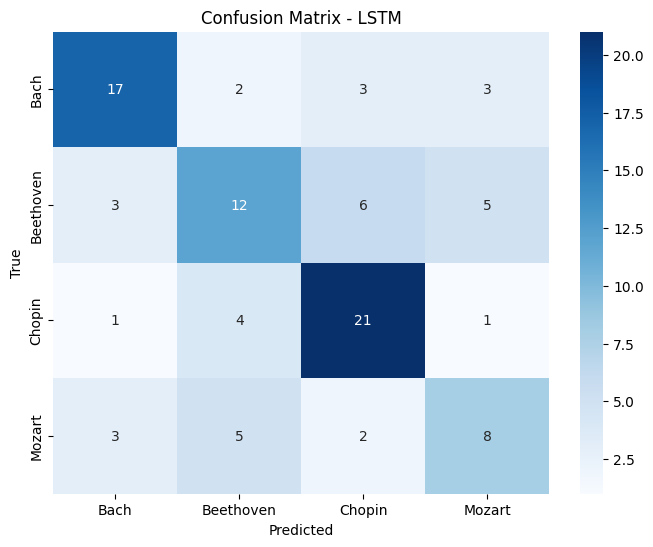

In [25]:
plot_confusion_matrix(lstm_model, test_loader, label_encoder_classes, 'Confusion Matrix - LSTM')

In [19]:
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
train(cnn_model,train_loader, criterion, cnn_optimizer, epochs=num_epochs)

Epoch 1/20, Loss: 8.3172
Epoch 2/20, Loss: 1.3529
Epoch 3/20, Loss: 1.2151
Epoch 4/20, Loss: 1.1484
Epoch 5/20, Loss: 1.0662
Epoch 6/20, Loss: 1.1287
Epoch 7/20, Loss: 1.0704
Epoch 8/20, Loss: 1.0697
Epoch 9/20, Loss: 0.9962
Epoch 10/20, Loss: 0.9040
Epoch 11/20, Loss: 0.9232
Epoch 12/20, Loss: 0.8717
Epoch 13/20, Loss: 0.7970
Epoch 14/20, Loss: 0.8170
Epoch 15/20, Loss: 0.8264
Epoch 16/20, Loss: 0.7913
Epoch 17/20, Loss: 0.7817
Epoch 18/20, Loss: 0.8157
Epoch 19/20, Loss: 0.7064
Epoch 20/20, Loss: 0.6494


In [24]:
cnn_val_accuracy = evaluate(cnn_model, val_loader)
print(f'Validation Accuracy: {cnn_val_accuracy:.2f}%')
# Evaluate the model on the test set
cnn_test_accuracy = evaluate(cnn_model, test_loader)
print(f'Test Accuracy of CNN model: {cnn_test_accuracy:.2f}%')

Validation Accuracy: 54.17%
Test Accuracy of CNN model: 51.04%


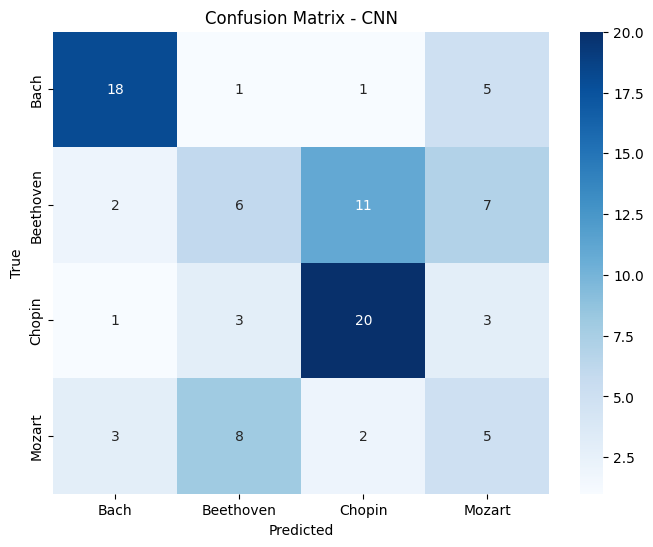

In [26]:
plot_confusion_matrix(cnn_model, test_loader, label_encoder_classes, 'Confusion Matrix - CNN')